<a href="https://colab.research.google.com/github/Rin4797/uniform_coverage_of_gans/blob/main/notebooks/mnist_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
! git clone https://github.com/Rin4797/uniform_coverage_of_gans

Cloning into 'uniform_coverage_of_gans'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Receiving objects: 100% (34/34), 26.37 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
from uniform_coverage_of_gans.models.ae import AutoEncoder
from uniform_coverage_of_gans.models.dcgan import Generator, Discriminator

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
ae = AutoEncoder().to(device)
ae.load_state_dict(torch.load('./uniform_coverage_of_gans/artifacts/mnist/ae.pt'))

<All keys matched successfully>

In [7]:
netG = Generator().to(device)
netG.load_state_dict(torch.load('./uniform_coverage_of_gans/artifacts/mnist/Generator.pt'))

<All keys matched successfully>

In [8]:
netD = Discriminator().to(device)
netD.load_state_dict(torch.load('./uniform_coverage_of_gans/artifacts/mnist/Discriminator.pt'))

<All keys matched successfully>

In [12]:
mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

batch_size = 64

train_dataset = MNIST('./mnist_root', train=True, transform=mnist_transforms, download=True)
test_dataset = MNIST('./mnist_root', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12872398.78it/s]


Extracting ./mnist_root/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 344660.32it/s]


Extracting ./mnist_root/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3196799.17it/s]


Extracting ./mnist_root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5523493.41it/s]

Extracting ./mnist_root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw



In [33]:
ae.eval()
latent_mnist = [
    ae.get_latent_features(x.to(device)).detach().to('cpu').view(batch_size, -1) for x, _ in tqdm(test_loader)
]
latent_mnist = torch.cat(latent_mnist, dim=0).numpy()

  0%|          | 0/156 [00:00<?, ?it/s]

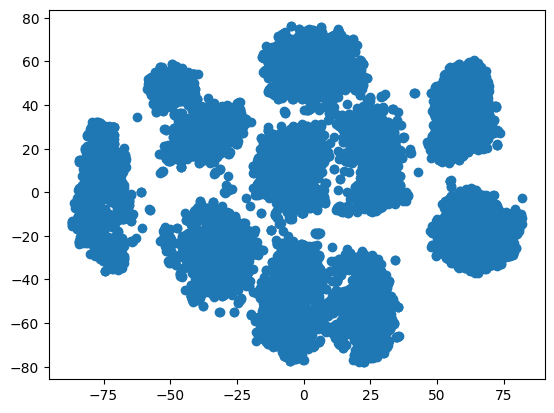

In [14]:
from sklearn.manifold import TSNE
# посмотрим на проекцию латентного пространства, полученного с помощью алгоритма TNSE

tsne = TSNE()
tsne_mnist = tsne.fit_transform(latent_mnist)
plt.scatter(tsne_mnist[:, 0], tsne_mnist[:, 1])
plt.show()

Ну довольно адекватная кластеризация.

Попробуем посмотре на то, как будут выглядеть сгенерированные изображения в таком представлении.

In [15]:
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [20]:
viz_noise = torch.randn(batch_size, 100, 1, 1, device=device)
img_list = []
with torch.no_grad():
    fake = netG(viz_noise).detach().cpu()
img_list = vutils.make_grid(fake, padding=2, normalize=True)

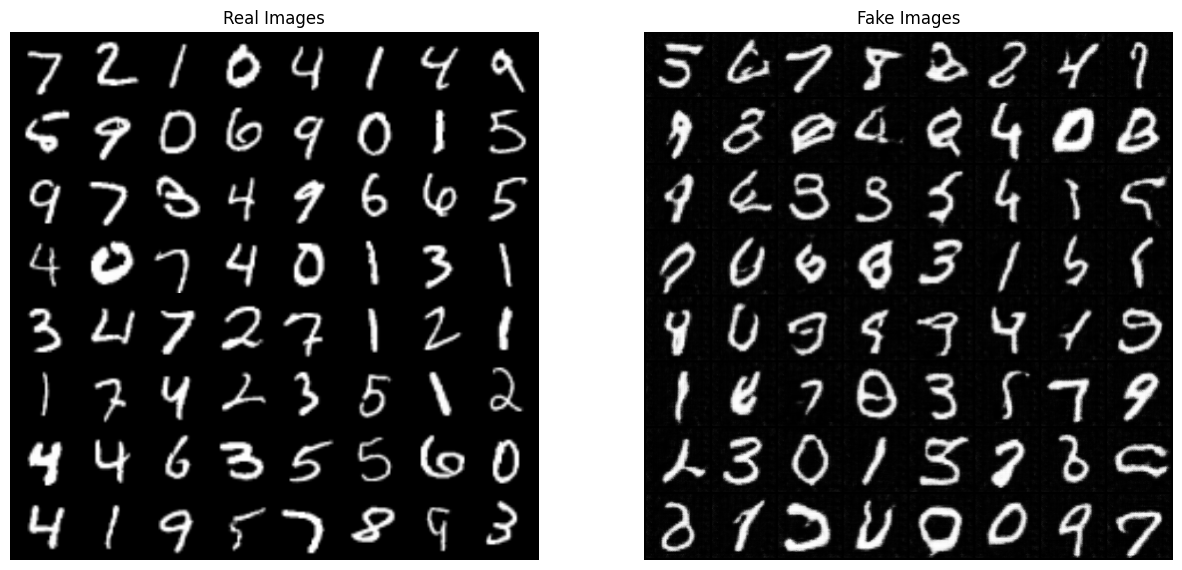

In [21]:
real_batch = next(iter(test_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list,(1,2,0)))
plt.show()

In [34]:
ae.eval()
latent_fake_mnist = [
    ae.get_latent_features(fake.to(device)).detach().to('cpu').view(batch_size, -1)
]
latent_fake_mnist = torch.cat(latent_fake_mnist, dim=0).numpy()

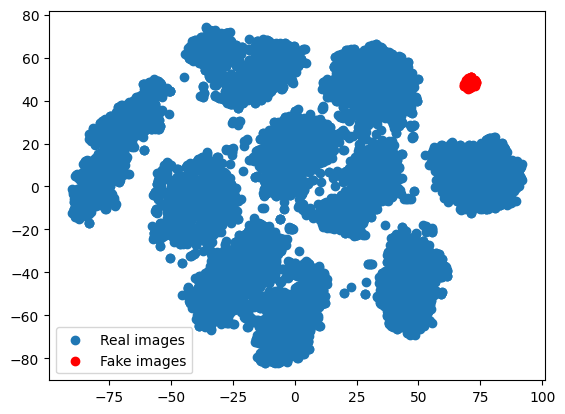

In [45]:
tsne = TSNE()
all_latent = np.concatenate((latent_mnist, latent_fake_mnist))
tsne_all = tsne.fit_transform(all_latent)
tsne_mnist, tsne_fake_mnist = tsne_all[:latent_mnist.shape[0]], tsne_all[latent_mnist.shape[0]:]
plt.scatter(tsne_mnist[:, 0], tsne_mnist[:, 1], label='Real images')
plt.scatter(tsne_fake_mnist[:, 0], tsne_fake_mnist[:, 1], color='r', label='Fake images')
plt.legend()
plt.show()

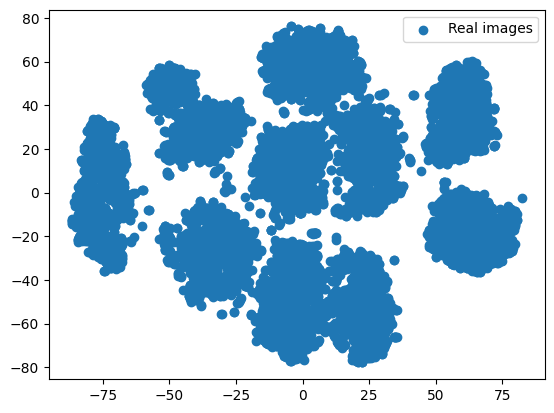

In [46]:
tsne = TSNE()
tsne_mnist = tsne.fit_transform(latent_mnist)
plt.scatter(tsne_mnist[:, 0], tsne_mnist[:, 1], label='Real images')
plt.legend()
plt.show()

Как мы можем видеть, TSNE не сильно деформирует исходное распределение при добавлении к нему датасета фальшивых изображений, так что можно принять полученное изображение как более-менее правдоподобную проекцию объектов из латентного пространства автоэнкодера.

Как мы можем видеть, генератор создает изображения достаточно правдоподобные, но вообще не подходящие под исходное распределение. Более того, полученные изображения довольно скученные.

Можно предположить, что данную проблему можно решить с помощью использования более сложной модели.